### CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, regularizers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from src.dataLoading import dataLoader
from sklearn.model_selection import train_test_split
import itertools


In [2]:
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


#### Load Data

In [73]:
vectors, images, labels = dataLoader(mnist_only=False, chinese_mnist_only=False)  # 784-long vectors, 28*28 images and mnist/chinese labels

encoder = LabelBinarizer()
transfomed_labels = encoder.fit(np.unique(labels))
# split the vectors (for PCA, CNN would use images)
# "stratify" makes sure theres a balance of each class in the test/train sets
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, train_size=0.8, stratify=labels)
y_train_t = encoder.transform(y_train)
y_test_t = encoder.transform(y_test)

In [74]:
X_train = np.reshape(X_train, (X_train.shape[0],28,28,1))
X_test = np.reshape(X_test, (X_test.shape[0],28,28,1))

In [9]:
BATCH_SIZE=64
STEPS_PER_EPOCH = X_train.shape[0]//BATCH_SIZE

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)


def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=None, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)),
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=0.00, l2=0.00), activation='relu'))
    model.add(layers.Dropout(0.3)),
    model.add(layers.Dense(32, kernel_regularizer=regularizers.L1L2(l1=0.00, l2=0.00), activation='relu'))
    model.add(layers.Dropout(0.3)),
    model.add(layers.Dense(output_shape))
    return model

In [10]:
model = create_model(X_train.shape[1:], y_train_t.shape[-1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0

In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_t, epochs=50, batch_size=64,
                    validation_split=0.1, callbacks=callbacks)

Epoch 1/50
225/225 [==============================] - 37s 126ms/step - loss: 1.2915 - accuracy: 0.6040 - val_loss: 0.2836 - val_accuracy: 0.9325
Epoch 2/50
225/225 [==============================] - 28s 123ms/step - loss: 0.4368 - accuracy: 0.8697 - val_loss: 0.1073 - val_accuracy: 0.9712
Epoch 3/50
225/225 [==============================] - 18s 80ms/step - loss: 0.2938 - accuracy: 0.9135 - val_loss: 0.0729 - val_accuracy: 0.9806
Epoch 4/50
225/225 [==============================] - 2s 9ms/step - loss: 0.2199 - accuracy: 0.9371 - val_loss: 0.0625 - val_accuracy: 0.9819
Epoch 5/50
225/225 [==============================] - 2s 9ms/step - loss: 0.1852 - accuracy: 0.9450 - val_loss: 0.0850 - val_accuracy: 0.9831
Epoch 6/50
225/225 [==============================] - 2s 9ms/step - loss: 0.1589 - accuracy: 0.9544 - val_loss: 0.0762 - val_accuracy: 0.9800
Epoch 7/50
225/225 [==============================] - 2s 9ms/step - loss: 0.1363 - accuracy: 0.9605 - val_loss: 0.0557 - val_accuracy: 0.988

### Grid Search

In [20]:
EPOCHS = 100
BATCH_SIZE = [32, 64]
l1 = [0.1, 0.01, 0.001]
l2 = [0.1, 0.01, 0.001]
dropouts = [0.5, 0.2]
conv_models = [
    [32, 64],
    [32, 64, 128],
    [16, 32],
    [16, 32, 64],
    [64, 128],
    # [64, 128, 256]
]
add_batch_norm = [True, False]
dense_models = [
    [32],
    # [128, 64],
    [64],
    [64, 32],
    # [128, 32],
    [128]
]
parameters = list(itertools.product(*[conv_models, add_batch_norm, dense_models, dropouts, BATCH_SIZE]))
print(f'total number of combinations: {len(parameters)}')

total number of combinations: 160


In [22]:
parameters

[([32, 64], True, [32], 0.5, 32),
 ([32, 64], True, [32], 0.5, 64),
 ([32, 64], True, [32], 0.2, 32),
 ([32, 64], True, [32], 0.2, 64),
 ([32, 64], True, [64], 0.5, 32),
 ([32, 64], True, [64], 0.5, 64),
 ([32, 64], True, [64], 0.2, 32),
 ([32, 64], True, [64], 0.2, 64),
 ([32, 64], True, [64, 32], 0.5, 32),
 ([32, 64], True, [64, 32], 0.5, 64),
 ([32, 64], True, [64, 32], 0.2, 32),
 ([32, 64], True, [64, 32], 0.2, 64),
 ([32, 64], True, [128], 0.5, 32),
 ([32, 64], True, [128], 0.5, 64),
 ([32, 64], True, [128], 0.2, 32),
 ([32, 64], True, [128], 0.2, 64),
 ([32, 64], False, [32], 0.5, 32),
 ([32, 64], False, [32], 0.5, 64),
 ([32, 64], False, [32], 0.2, 32),
 ([32, 64], False, [32], 0.2, 64),
 ([32, 64], False, [64], 0.5, 32),
 ([32, 64], False, [64], 0.5, 64),
 ([32, 64], False, [64], 0.2, 32),
 ([32, 64], False, [64], 0.2, 64),
 ([32, 64], False, [64, 32], 0.5, 32),
 ([32, 64], False, [64, 32], 0.5, 64),
 ([32, 64], False, [64, 32], 0.2, 32),
 ([32, 64], False, [64, 32], 0.2, 64),


In [12]:
def create_model_2(input_shape, output_shape, conv_layers, batch_norm, dense_layers, dropout, steps_per_epoch):
    model = tf.keras.models.Sequential()
    for idx, val in enumerate(conv_layers):
        if(idx == 0):
            model.add(layers.Conv2D(val, (3, 3), activation=None, input_shape=input_shape))
        else:
            model.add(layers.Conv2D(val, (3, 3), activation=None))
        if(batch_norm):
            model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout)),
    for idx, val in enumerate(dense_layers):
        model.add(layers.Dense(val, kernel_regularizer=regularizers.L1L2(l1=0.00, l2=0.00), activation='relu'))
        model.add(layers.Dropout(dropout)),
    model.add(layers.Dense(output_shape))
       
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=steps_per_epoch*1000,
      decay_rate=1,
      staircase=False)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model


### Cross Validation

In [51]:
def cross_validate(conv_model, batch_norm, dense_model, dropout, batch_size, k_folds=10):
    acc_per_fold = []
    loss_per_fold = []
    num_folds = 2
    kfold = KFold(n_splits=num_folds, shuffle=True)
    fold_n = 1
    for train, test in kfold.split(X_train, y_train_t):
        print(f'FOLD {fold_n}')
        model = create_model_2(X_train.shape[1:], y_train_t.shape[-1], conv_model, batch_norm, dense_model, dropout,  X_train.shape[0]//batch_size)
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        ]
        history = model.fit(
            X_train[train],
            y_train_t[train],
            epochs=5,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=2,
            callbacks=callbacks
        )
        test_loss, test_acc = model.evaluate(X_train[test], y_train_t[test], verbose=2)
        print(X_train[test].shape, y_train_t[test].shape)
        print(f'Score for fold {fold_n}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc*100}%')
        acc_per_fold.append(test_acc * 100)
        loss_per_fold.append(test_loss)
        fold_n += 1
    return [np.mean(acc_per_fold), np.mean(loss_per_fold)]

In [52]:
means = [cross_validate(conv_model, batch_norm, dense_model, dropout, batch_size) for conv_model, batch_norm, dense_model, dropout, batch_size in parameters[:1]]

FOLD 1
Epoch 1/5
225/225 - 2s - loss: 2.7481 - accuracy: 0.1228 - val_loss: 2.2692 - val_accuracy: 0.3113
Epoch 2/5
225/225 - 1s - loss: 2.3549 - accuracy: 0.2147 - val_loss: 2.0044 - val_accuracy: 0.4087
Epoch 3/5
225/225 - 1s - loss: 2.2364 - accuracy: 0.2422 - val_loss: 1.6780 - val_accuracy: 0.4762
Epoch 4/5
225/225 - 1s - loss: 2.0274 - accuracy: 0.3004 - val_loss: 1.2177 - val_accuracy: 0.7600
Epoch 5/5
225/225 - 1s - loss: 1.8285 - accuracy: 0.3742 - val_loss: 1.0182 - val_accuracy: 0.8138
250/250 - 1s - loss: 0.9887 - accuracy: 0.8195
(8000, 28, 28, 1) (8000, 20)
Score for fold 1: loss of 0.9887358546257019; accuracy of 81.95000290870667%
FOLD 2
Epoch 1/5
225/225 - 2s - loss: 2.6968 - accuracy: 0.1660 - val_loss: 1.8775 - val_accuracy: 0.5362
Epoch 2/5
225/225 - 1s - loss: 2.0738 - accuracy: 0.3300 - val_loss: 1.0546 - val_accuracy: 0.7937
Epoch 3/5
225/225 - 1s - loss: 1.7313 - accuracy: 0.4411 - val_loss: 0.7268 - val_accuracy: 0.8750
Epoch 4/5
225/225 - 1s - loss: 1.5460 - a

In [37]:
np.array(means)[:,:]

array([[9.88874996e+01, 4.46845509e-02],
       [9.84562498e+01, 6.14750601e-02]])

In [41]:
top_params = [parameters[idx] for idx in np.argsort(np.array(means)[:,0])[::-1][:3]]
print('Top model Configurations')
print(top_params)

Top model Configurations
[([32, 64], True, [64], 0.5, 64), ([32, 64], False, [64], 0.5, 64)]


In [43]:
top_means = [means[idx] for idx in np.argsort(np.array(means)[:,0])[::-1][:3]]
print('Top mean accuracies and losses')
print(top_means)

Top mean accuracies and losses
[[98.88749957084656, 0.04468455091118813], [98.456249833107, 0.06147506013512612]]


### Final Model

In [5]:
import os,sys


In [6]:
os.path.abspath('')

'H:\\My Drive\\Master\\Machine_Learning\\MachineLearning-2022'

In [32]:
fname = os.path.sep.join([os.path.abspath(''), 'saved_models',
	"weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
final_callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1)
]

In [33]:
([16, 32], True, [128], 0.5, 32)

([16, 32], True, [128], 0.5, 32)

In [34]:
STEPS_PER_EPOCH = X_train.shape[0]//32
print(STEPS_PER_EPOCH)

500


In [61]:
model = create_model_2(X_train.shape[1:], y_train_t.shape[-1], [16, 32], True, [128], 0.5, STEPS_PER_EPOCH)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(X_train, y_train_t, epochs=200, batch_size=32,
                    validation_split=0.1, callbacks=final_callbacks)

Epoch 1/200
450/450 [==============================] - 4s 8ms/step - loss: 1.3839 - accuracy: 0.5899 - val_loss: 0.2602 - val_accuracy: 0.9331

Epoch 00001: val_accuracy did not improve from 0.98937
Epoch 2/200
450/450 [==============================] - 4s 8ms/step - loss: 0.4834 - accuracy: 0.8528 - val_loss: 0.1425 - val_accuracy: 0.9644

Epoch 00002: val_accuracy did not improve from 0.98937
Epoch 3/200
450/450 [==============================] - 4s 8ms/step - loss: 0.3221 - accuracy: 0.9014 - val_loss: 0.1109 - val_accuracy: 0.9750

Epoch 00003: val_accuracy did not improve from 0.98937
Epoch 4/200
450/450 [==============================] - 4s 9ms/step - loss: 0.2621 - accuracy: 0.9187 - val_loss: 0.0963 - val_accuracy: 0.9762

Epoch 00004: val_accuracy did not improve from 0.98937
Epoch 5/200
450/450 [==============================] - 4s 9ms/step - loss: 0.2212 - accuracy: 0.9345 - val_loss: 0.1034 - val_accuracy: 0.9756

Epoch 00005: val_accuracy did not improve from 0.98937
Epoch

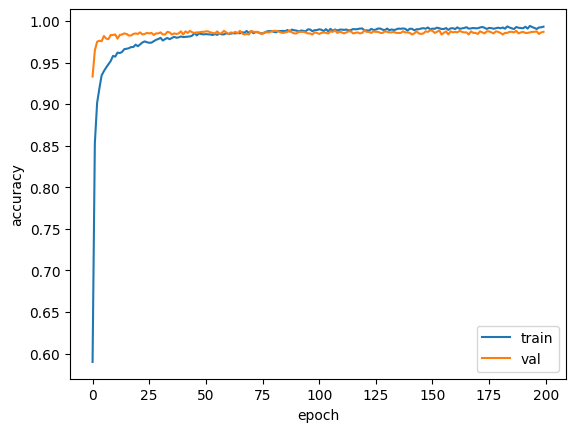

In [122]:
ax= plt.subplot()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
# plt.show()
plt.savefig('figures/cnn_accuracy.png')

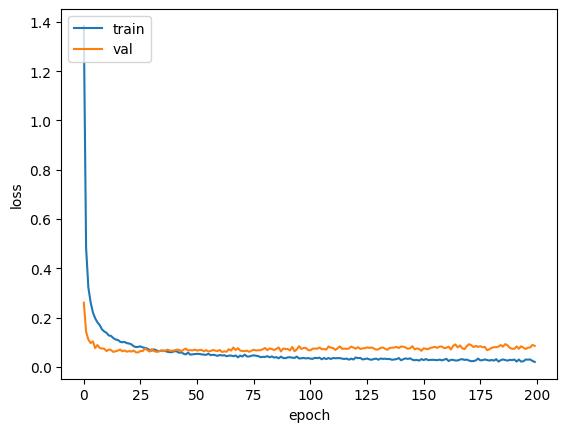

In [120]:
ax = plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()
plt.savefig('figures/cnn_loss.png')

In [67]:
model = tf.keras.models.load_model('saved_models/weights-087-0.0746.hdf5')
model.summary()
test_loss, test_acc = model.evaluate(X_test[:], y_test_t[:], verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 11, 11, 32)       

In [68]:
model_best = tf.keras.models.load_model('saved_models/weights-087-0.0746.hdf5')
model_best.summary()
test_loss, test_acc = model_best.evaluate(X_test[:], y_test_t[:], verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 11, 11, 32)       

In [69]:
model_best_2 = tf.keras.models.load_model('saved_models/weights-053-0.0694.hdf5')
model_best_2.summary()
test_loss, test_acc = model_best_2.evaluate(X_test[:], y_test_t[:], verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 11, 11, 32)       

In [90]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
y_test_pred = model_best.predict(X_test[:])
cm = confusion_matrix(encoder.inverse_transform(y_test_pred),y_test)

In [118]:
from sklearn.metrics import classification_report

print(classification_report(y_test, encoder.inverse_transform(y_test_pred), target_names=encoder.classes_, digits=4))


              precision    recall  f1-score   support

   chinese_0     1.0000    1.0000    1.0000       200
   chinese_1     1.0000    1.0000    1.0000       200
   chinese_2     0.9950    0.9950    0.9950       200
   chinese_3     1.0000    0.9950    0.9975       200
   chinese_4     1.0000    1.0000    1.0000       200
   chinese_5     1.0000    1.0000    1.0000       200
   chinese_6     1.0000    1.0000    1.0000       200
   chinese_7     0.9950    1.0000    0.9975       200
   chinese_8     1.0000    1.0000    1.0000       200
   chinese_9     1.0000    0.9950    0.9975       200
     mnist_0     1.0000    1.0000    1.0000       200
     mnist_1     1.0000    1.0000    1.0000       200
     mnist_2     0.9900    0.9900    0.9900       200
     mnist_3     1.0000    0.9950    0.9975       200
     mnist_4     0.9852    1.0000    0.9926       200
     mnist_5     1.0000    1.0000    1.0000       200
     mnist_6     1.0000    1.0000    1.0000       200
     mnist_7     0.9851    

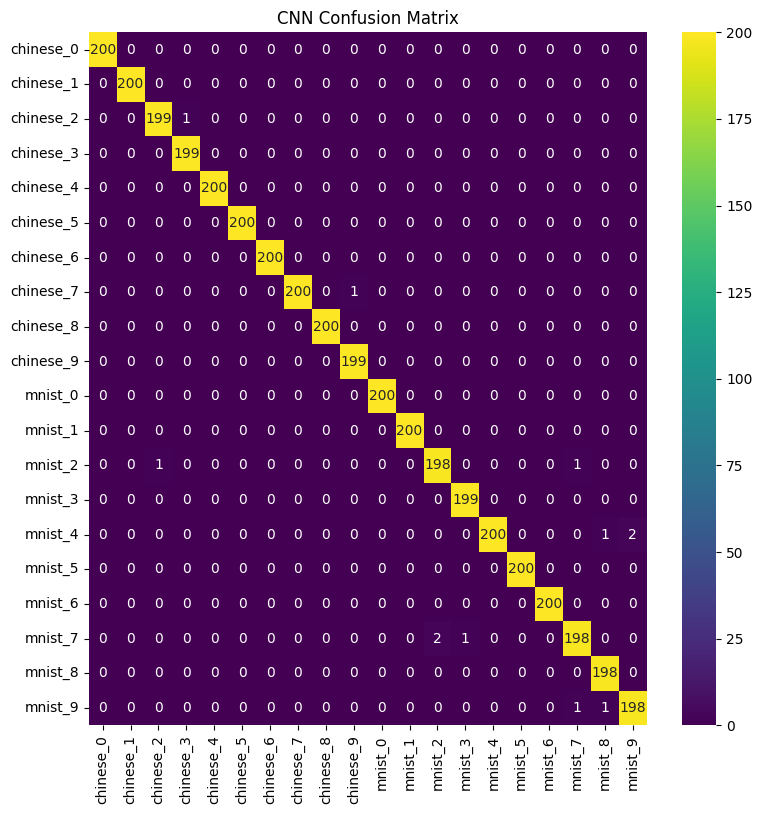

In [119]:
plt.figure(figsize=(9,9))
ax= plt.subplot()
cm_array_df = pd.DataFrame(cm, index=pd.Index(encoder.classes_), columns=encoder.classes_)
sns.heatmap(cm_array_df, annot=True, ax=ax, cmap='viridis', fmt='g')
plt.title('CNN Confusion Matrix')
plt.savefig('figures/cm_cnn.png')